This notebooks serves as an example on how to run the model, by splitting the training into train and validation, and see how well it does on the validation set.

In [1]:
from utils_data import load_data,scale_props,get_graphs
from utils_plotting import plot_property_histograms
from sklearn.model_selection import train_test_split
from utils_model import train_and_validate_multi,get_preds_per_task,vals_to_df
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP
import torch
import pandas as pd

In [2]:
#with the changes to the code, calc the stats might not be going right, maybe use this instead:
def print_stats(ys,preds,prop):
    from sklearn.metrics import mean_squared_error, r2_score
    rmse = mean_squared_error(ys,preds,squared=False)
    r2_vp = r2_score(ys,preds)
    print('RMSE',prop,':',rmse)
    print('R2',prop,':',r2_vp)


def print_rmse_and_r2_unscaled(preds,ys):
    preds_vp = preds[0]
    preds_p = preds[1]
    ys_vp = ys[0]
    ys_p = ys[1]
    preds_vp =[p for p in preds_vp if p != -1]
    preds_p =[p for p in preds_p if p != -1]
    ys_vp =[p for p in ys_vp if p != -1]
    ys_p =[p for p in ys_p if p != -1]
    print_stats(ys_vp,preds_vp,'LogVP')
    print_stats(ys_p,preds_p,'LogP')


def print_rmse_and_r2_scaled(df_preds,df_ys):
    preds_vp = df_preds['LogVP'].dropna().values
    preds_p = df_preds['LogP'].dropna().values
    ys_vp = df_ys['LogVP'].dropna().values
    ys_p = df_ys['LogP'].dropna().values
    print_stats(ys_vp,preds_vp,'LogVP')
    print_stats(ys_p,preds_p,'LogP')

In [3]:
train = pd.read_csv("train.csv")
train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)

Loading previously created graphs


In [5]:
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=['LogVP','LogP'],name='test_DASH_scaled')

Device: cuda
14686 3672
Epoch 1/100: Train Loss: 0.1434, Val Loss: 0.0724
Epoch 2/100: Train Loss: 0.0677, Val Loss: 0.0755
Epoch 3/100: Train Loss: 0.0619, Val Loss: 0.0673
Epoch 4/100: Train Loss: 0.0585, Val Loss: 0.0658
Epoch 5/100: Train Loss: 0.0574, Val Loss: 0.0569
Epoch 6/100: Train Loss: 0.0566, Val Loss: 0.0566
Epoch 7/100: Train Loss: 0.0549, Val Loss: 0.0617
Epoch 8/100: Train Loss: 0.0546, Val Loss: 0.0675
Epoch 9/100: Train Loss: 0.0553, Val Loss: 0.0604
Epoch 10/100: Train Loss: 0.0527, Val Loss: 0.0527
Epoch 11/100: Train Loss: 0.0534, Val Loss: 0.0613
Epoch 12/100: Train Loss: 0.0528, Val Loss: 0.0702
Epoch 13/100: Train Loss: 0.0540, Val Loss: 0.0572
Epoch 14/100: Train Loss: 0.0511, Val Loss: 0.0514
Epoch 15/100: Train Loss: 0.0510, Val Loss: 0.0544
Epoch 16/100: Train Loss: 0.0516, Val Loss: 0.0540
Epoch 17/100: Train Loss: 0.0521, Val Loss: 0.0512
Epoch 18/100: Train Loss: 0.0507, Val Loss: 0.0543
Epoch 19/100: Train Loss: 0.0531, Val Loss: 0.0558
Epoch 20/100: Tr

In [6]:
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load('test_DASH_scaled.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=['LogVP','LogP'])

2594


In [7]:
df_preds = vals_to_df(preds,['LogVP','LogP'])
df_ys = vals_to_df(ys,['LogVP','LogP'])

In [8]:
vps_pred = df_preds['LogVP'].dropna().values
ps_pred = df_preds['LogP'].dropna().values
vps = df_ys['LogVP'].dropna().values
ps = df_ys['LogP'].dropna().values
#rmse
from sklearn.metrics import mean_squared_error
mean_squared_error(vps_pred,vps,squared=False),mean_squared_error(ps_pred,ps,squared=False)

(1.399740430362038, 0.7293428541029845)

RMSE LogVP : 1.399740430362038
R2 LogVP : 0.8627499214485491
RMSE LogP : 0.7293428541029845
R2 LogP : 0.8466555238111069
None
-----------------------------------
Property: LogVP
kendall_tau: 0.8014196654927557
rmse_overall: 1.399740430362038
mae_overall: 0.9371933403870719
within_03_overall: 0.25060827250608275
within_1_overall: 0.6958637469586375
R2: 0.8627499214485491
Pearson: 0.9304867947185052


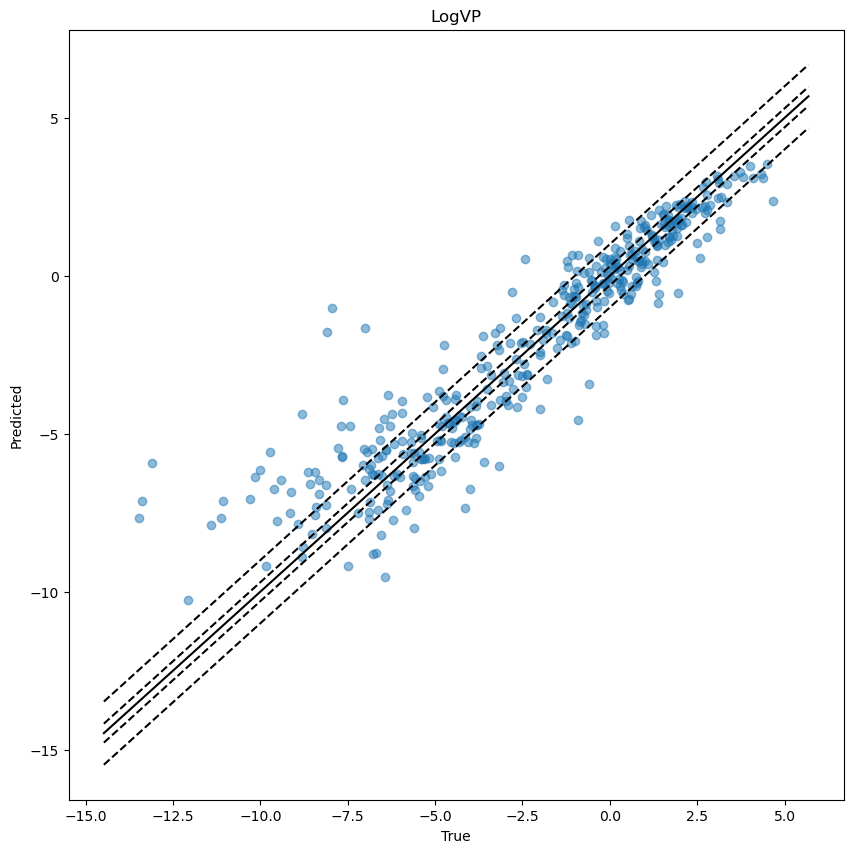

Property: LogP
kendall_tau: 0.7456723634661478
rmse_overall: 0.7293428541029845
mae_overall: 0.5421191629532262
within_03_overall: 0.3756298671552909
within_1_overall: 0.8648648648648649
R2: 0.8466555238111069
Pearson: 0.9202407065096174


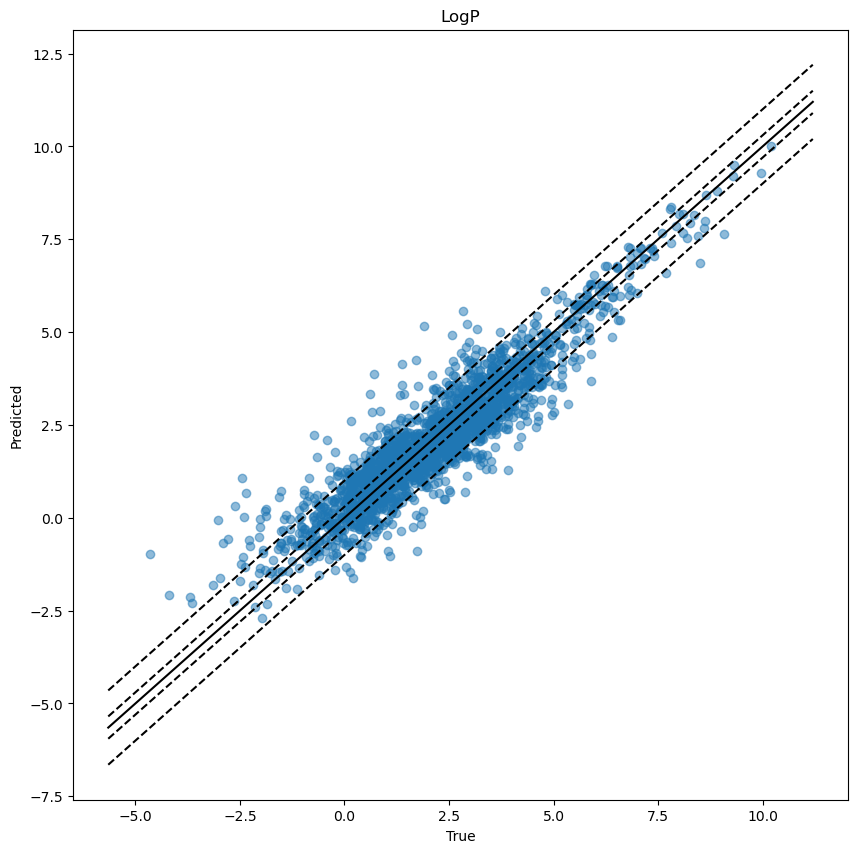

In [9]:
#plot
from utils_plotting import plot_scatters
print(print_rmse_and_r2_scaled(df_preds,df_ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)

In [19]:
#compare to using the unscaled DASH charges
train = pd.read_csv("train.csv")
outputs = 14
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_graphs_DASH_charge_unscaled = get_graphs(train,dash_charges=True,scaled =False,save_graphs = True)
train_data, val_data = train_test_split(train_graphs_DASH_charge_unscaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=['LogVP','LogP'],name='test_DASH_unscaled')

Loading previously created graphs
14686 3672


2629
RMSE LogVP : 0.9626625825999022
R2 LogVP : 0.9325500983861174
RMSE LogP : 0.4724271468496287
R2 LogP : 0.9328288917044089
None
-----------------------------------
Property: LogVP
kendall_tau: 0.9185062454392551
rmse_overall: 0.337373546398303
mae_overall: 0.06729860200743497
within_03_overall: 0.9400871459694989
within_1_overall: 0.9828431372549019
R2: 0.938618216214506
Pearson: 0.9689098303803632


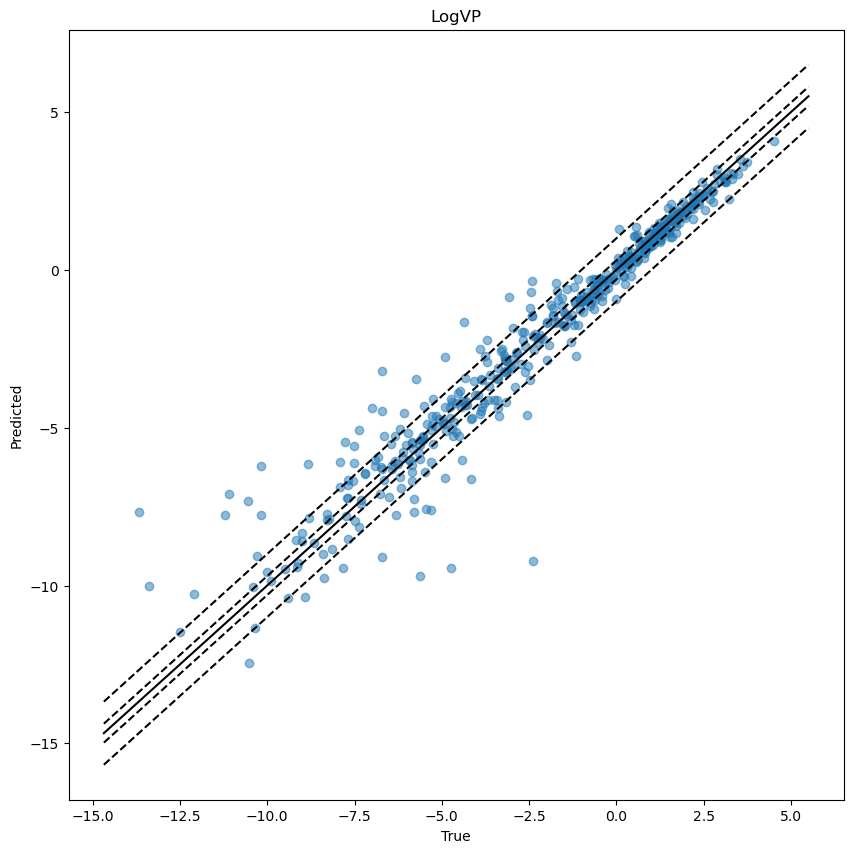

Property: LogP
kendall_tau: 0.9205858647361814
rmse_overall: 0.363841678688241
mae_overall: 0.19556190800997134
within_03_overall: 0.7540849673202614
within_1_overall: 0.9773965141612201
R2: 0.9693039300608861
Pearson: 0.9849554202624657


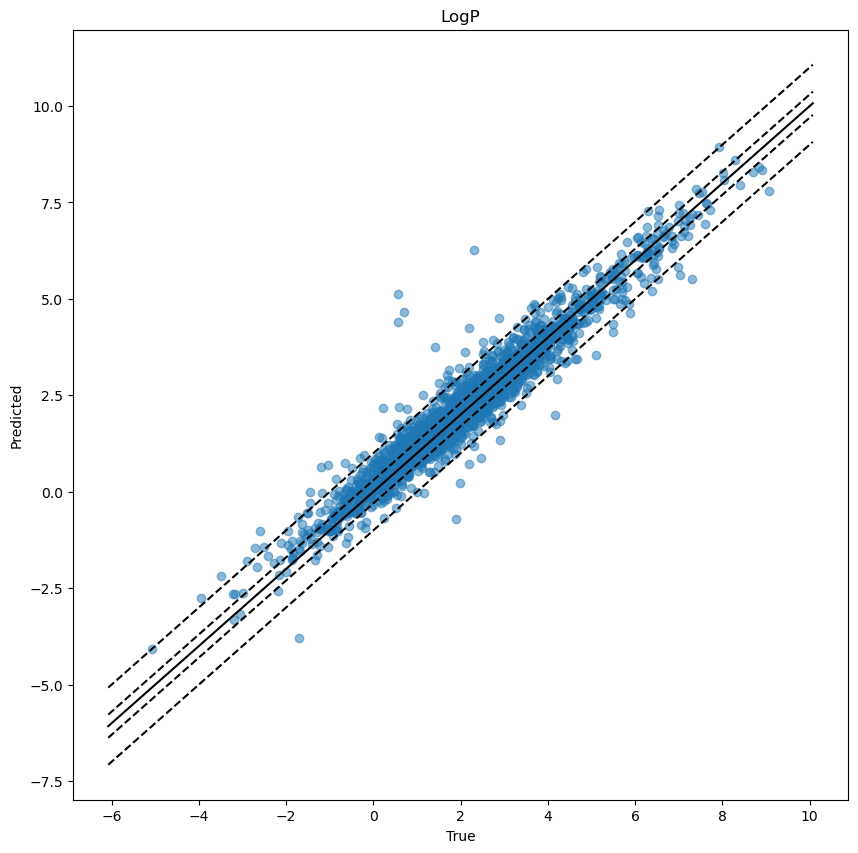

In [22]:
from utils_model import get_preds_per_task,vals_to_df
from utils_plotting import plot_scatters
model.load_state_dict(torch.load('test_DASH_unscaled.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=['LogVP','LogP'])
df_preds = vals_to_df(preds,['LogVP','LogP'],scaled=False)
df_ys = vals_to_df(ys,['LogVP','LogP'],scaled=False)
print(print_rmse_and_r2_unscaled(preds,ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)

In [23]:
#and compare to not using charges
train_graphs_no_charge_scaled = get_graphs(train,dash_charges=False,scaled =True,save_graphs = True)
train_data, val_data = train_test_split(train_graphs_no_charge_scaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=['LogVP','LogP'],name='test_no_charge_scaled')

Loading previously created graphs
14865 3717
Epoch 1/100: Train Loss: 0.1099, Val Loss: 0.0735
Epoch 2/100: Train Loss: 0.0695, Val Loss: 0.0694
Epoch 3/100: Train Loss: 0.0644, Val Loss: 0.0633
Epoch 4/100: Train Loss: 0.0633, Val Loss: 0.0632
Epoch 5/100: Train Loss: 0.0615, Val Loss: 0.0648
Epoch 6/100: Train Loss: 0.0615, Val Loss: 0.0603
Epoch 7/100: Train Loss: 0.0611, Val Loss: 0.0576
Epoch 8/100: Train Loss: 0.0592, Val Loss: 0.0613
Epoch 9/100: Train Loss: 0.0590, Val Loss: 0.0652
Epoch 10/100: Train Loss: 0.0582, Val Loss: 0.0571
Epoch 11/100: Train Loss: 0.0579, Val Loss: 0.0570
Epoch 12/100: Train Loss: 0.0576, Val Loss: 0.0627
Epoch 13/100: Train Loss: 0.0570, Val Loss: 0.0589
Epoch 14/100: Train Loss: 0.0568, Val Loss: 0.0584
Epoch 15/100: Train Loss: 0.0557, Val Loss: 0.0561
Epoch 16/100: Train Loss: 0.0556, Val Loss: 0.0584
Epoch 17/100: Train Loss: 0.0553, Val Loss: 0.0569
Epoch 18/100: Train Loss: 0.0548, Val Loss: 0.0574
Epoch 19/100: Train Loss: 0.0542, Val Loss: 0.

2722
RMSE LogVP : 1.3481938307574455
R2 LogVP : 0.8605379103116012
RMSE LogP : 0.793280943003242
R2 LogP : 0.806297574454731
None
-----------------------------------
Property: LogVP
kendall_tau: 0.7964976185822678
rmse_overall: 1.3481938307574455
mae_overall: 0.9627808546219073
within_03_overall: 0.240990990990991
within_1_overall: 0.6463963963963963
R2: 0.8605379103116012
Pearson: 0.9280493765315512


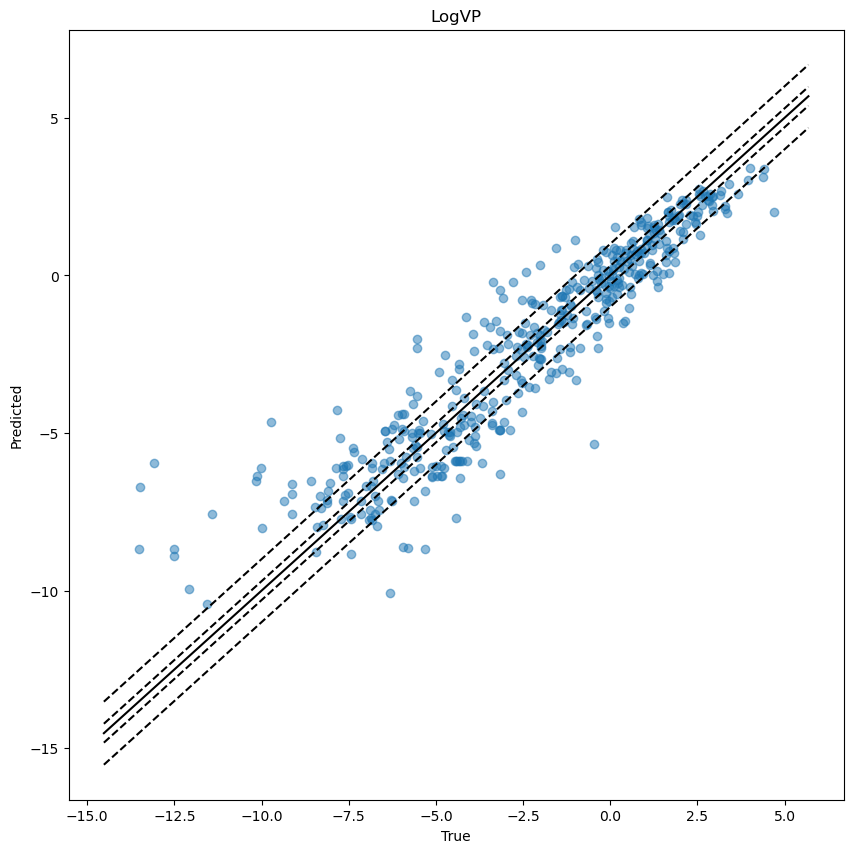

Property: LogP
kendall_tau: 0.7161065022299311
rmse_overall: 0.793280943003242
mae_overall: 0.5802135919380517
within_03_overall: 0.3652326602282704
within_1_overall: 0.8331870061457419
R2: 0.806297574454731
Pearson: 0.8981590941331006


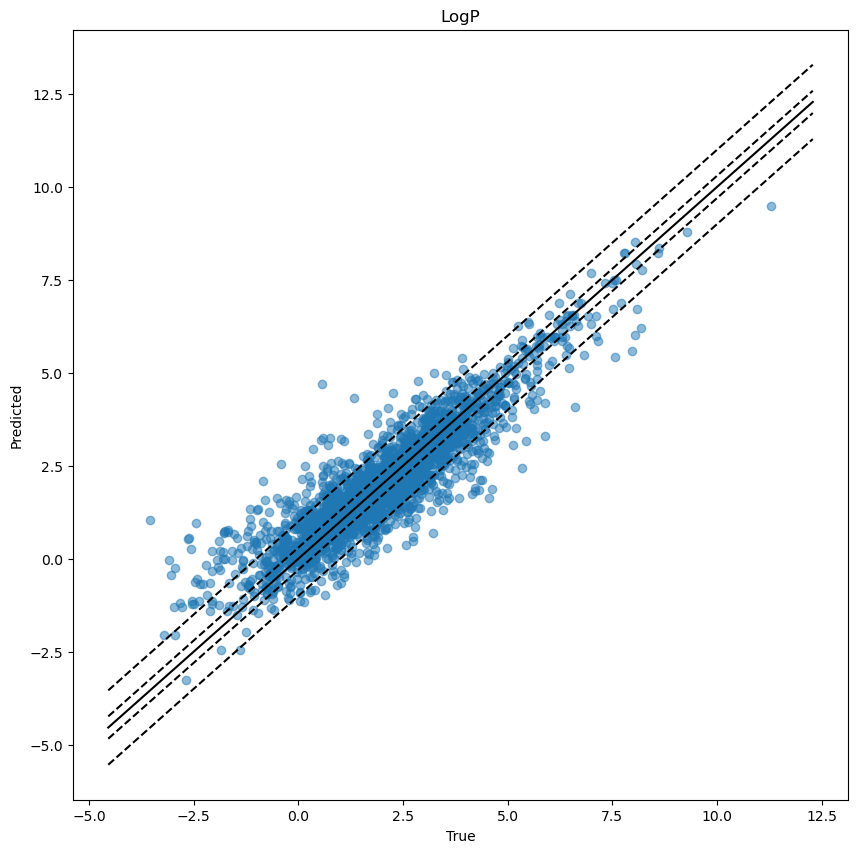

In [24]:
model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load('test_no_charge_scaled.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=['LogVP','LogP'])
df_preds = vals_to_df(preds,['LogVP','LogP'],scaled=True)
df_ys = vals_to_df(ys,['LogVP','LogP'],scaled=True)
print(print_rmse_and_r2_scaled(df_preds,df_ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)

In [25]:
#and compare to not using charges, no scaling

train_graphs_no_charge_unscaled = get_graphs(train,dash_charges=False,scaled =False,save_graphs = True)
train_data, val_data = train_test_split(train_graphs_no_charge_unscaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=['LogVP','LogP'],name='test_no_charge_unscaled')
model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load('test_no_charge_unscaled.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=['LogVP','LogP'])
df_preds = vals_to_df(preds,['LogVP','LogP'],scaled=True)
df_ys = vals_to_df(ys,['LogVP','LogP'],scaled=True)
print(print_rmse_and_r2_unscaled(preds,ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)

Loading previously created graphs
14865 3717
Epoch 1/100: Train Loss: 0.1037, Val Loss: 0.0839
Epoch 2/100: Train Loss: 0.0704, Val Loss: 0.0671
Epoch 3/100: Train Loss: 0.0646, Val Loss: 0.0720
Epoch 4/100: Train Loss: 0.0634, Val Loss: 0.0618
Epoch 5/100: Train Loss: 0.0628, Val Loss: 0.0603
Epoch 6/100: Train Loss: 0.0620, Val Loss: 0.0645
Epoch 7/100: Train Loss: 0.0613, Val Loss: 0.0597
Epoch 8/100: Train Loss: 0.0604, Val Loss: 0.0660
Epoch 9/100: Train Loss: 0.0604, Val Loss: 0.0615
Epoch 10/100: Train Loss: 0.0593, Val Loss: 0.0599
Epoch 11/100: Train Loss: 0.0590, Val Loss: 0.0586
Epoch 12/100: Train Loss: 0.0574, Val Loss: 0.0583
Epoch 13/100: Train Loss: 0.0587, Val Loss: 0.0581
Epoch 14/100: Train Loss: 0.0583, Val Loss: 0.0588
Epoch 15/100: Train Loss: 0.0576, Val Loss: 0.0590
Epoch 16/100: Train Loss: 0.0575, Val Loss: 0.0596
Epoch 17/100: Train Loss: 0.0561, Val Loss: 0.0580
Epoch 18/100: Train Loss: 0.0563, Val Loss: 0.0568
Epoch 19/100: Train Loss: 0.0558, Val Loss: 0.

KeyboardInterrupt: 

In [31]:
#test with some props that seem to be related at first glance: HL, KOA,LogP, MP,BP,VP
train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)
props = ['LogHL','LogKOA','LogP','MP','BP','LogVP']
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=props,name='test_DASH_scaled_6props')


Loading previously created graphs
14686 3672
Epoch 1/100: Train Loss: 0.0965, Val Loss: 0.0741
Epoch 2/100: Train Loss: 0.0734, Val Loss: 0.0693
Epoch 3/100: Train Loss: 0.0713, Val Loss: 0.0681
Epoch 4/100: Train Loss: 0.0679, Val Loss: 0.0698
Epoch 5/100: Train Loss: 0.0667, Val Loss: 0.0662
Epoch 6/100: Train Loss: 0.0652, Val Loss: 0.0665
Epoch 7/100: Train Loss: 0.0644, Val Loss: 0.0685
Epoch 8/100: Train Loss: 0.0630, Val Loss: 0.0627
Epoch 9/100: Train Loss: 0.0627, Val Loss: 0.0674
Epoch 10/100: Train Loss: 0.0618, Val Loss: 0.0639
Epoch 11/100: Train Loss: 0.0618, Val Loss: 0.0635
Epoch 12/100: Train Loss: 0.0610, Val Loss: 0.0610
Epoch 13/100: Train Loss: 0.0608, Val Loss: 0.0660
Epoch 14/100: Train Loss: 0.0603, Val Loss: 0.0628
Epoch 15/100: Train Loss: 0.0596, Val Loss: 0.0613
Epoch 16/100: Train Loss: 0.0591, Val Loss: 0.0610
Epoch 17/100: Train Loss: 0.0589, Val Loss: 0.0614
Epoch 18/100: Train Loss: 0.0588, Val Loss: 0.0586
Epoch 19/100: Train Loss: 0.0583, Val Loss: 0.

IndexError: tuple index out of range

In [49]:
default_properties = ['LogVP', 'LogP', 'LogOH', 'LogBCF', 'LogHalfLife', 'BP', 'Clint', 'FU', 'LogHL', 'LogKmHL', 'LogKOA', 'LogKOC', 'MP', 'LogMolar']

def get_preds_per_task(model,val_loader,outputs,props_to_predict):
    idx_to_pred = [default_properties.index(prop) for prop in props_to_predict]
    model.to(device)
    model.eval()
    preds = tuple([[] for i in range(len(props_to_predict))])
    ys = tuple([[] for i in range(len(props_to_predict))])
    counter = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        
        for i in range(outputs):
            if i not in idx_to_pred:
                continue

            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != -1).view(-1)

            counter += len(present_label_indices)

            # Create arrays with -1 values for indices not in present_label_indices
            preds_tmp = torch.full_like(y_tmp, -1)
            ys_tmp = torch.full_like(y_tmp, -1)

            if len(present_label_indices) > 0:
                # Replace -1 values with predictions and true values where available
                preds_tmp[present_label_indices] = out_tmp[present_label_indices]
                ys_tmp[present_label_indices] = y_tmp[present_label_indices]
            tupp_idx = props_to_predict.index(default_properties[i])
            preds[tupp_idx].extend(preds_tmp.detach().cpu().numpy().tolist())
            ys[tupp_idx].extend(ys_tmp.detach().cpu().numpy().tolist())

    print(counter)
    return preds, ys

4952
RMSE LogVP : 1.2547386617983936
R2 LogVP : 0.8897130446371445
RMSE LogP : 0.7808277738220799
R2 LogP : 0.824241969543288
None
-----------------------------------
Property: LogVP
kendall_tau: 0.8382406235228306
rmse_overall: 1.2547386617983936
mae_overall: 0.8229267616181201
within_03_overall: 0.2944038929440389
within_1_overall: 0.732360097323601
R2: 0.8897130446371445
Pearson: 0.9440506959012666


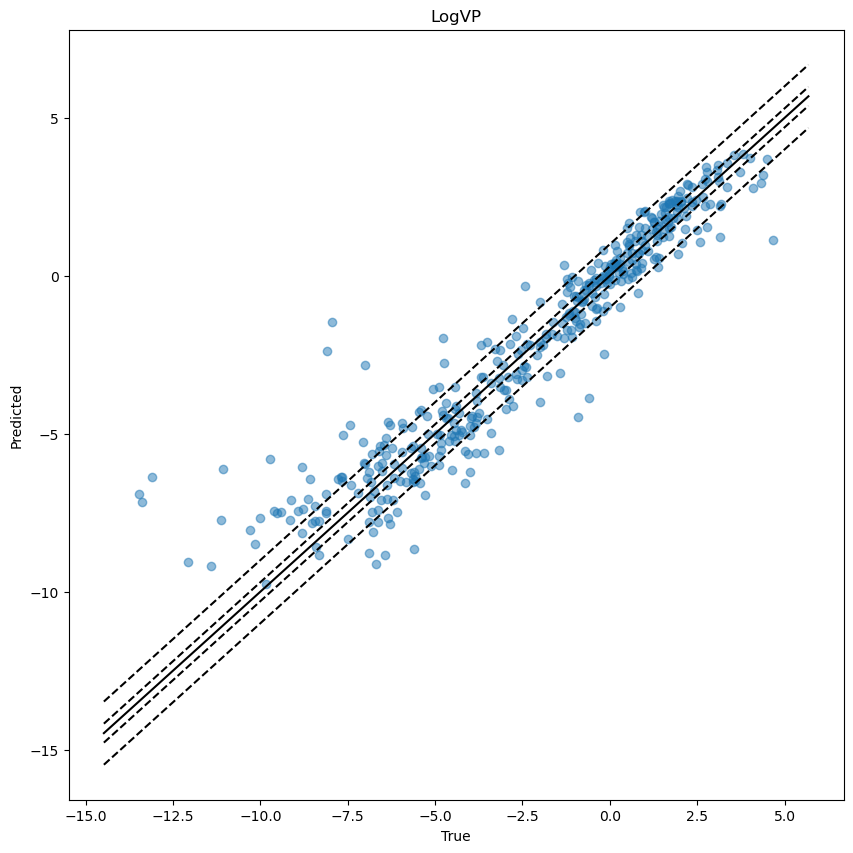

Property: LogP
kendall_tau: 0.7323411546886092
rmse_overall: 0.7808277738220799
mae_overall: 0.5719111918604775
within_03_overall: 0.36097114063215757
within_1_overall: 0.8460833715071003
R2: 0.824241969543288
Pearson: 0.9082514812561913


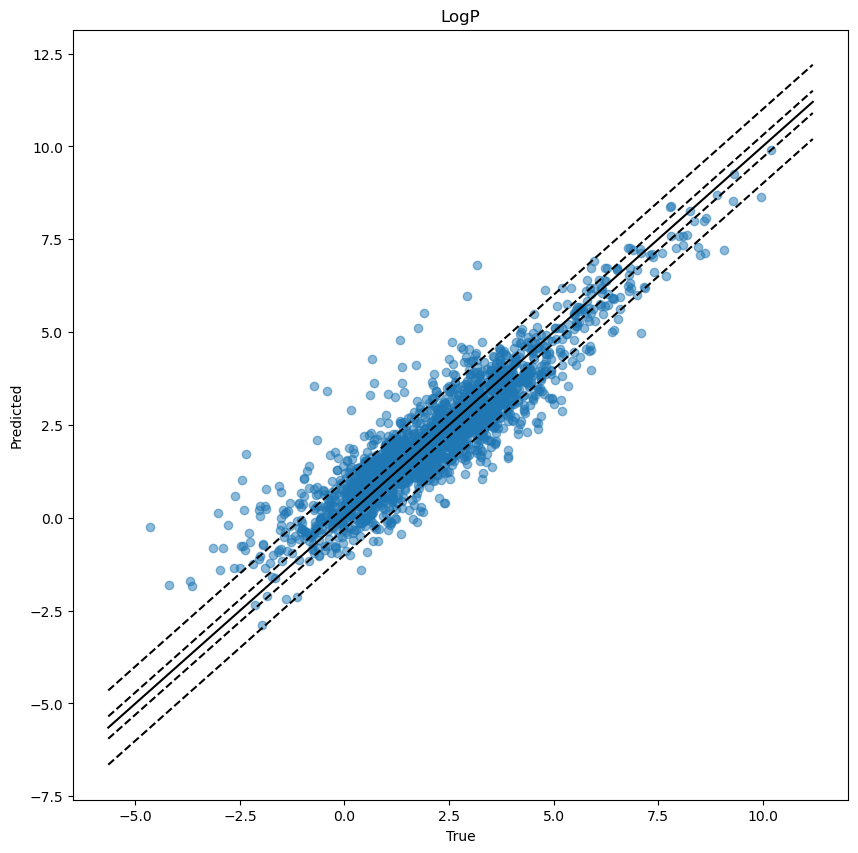

Property: BP
kendall_tau: 0.8223347640850319
rmse_overall: 26.749211115036506
mae_overall: 18.962388009187507
within_03_overall: 0.008433734939759036
within_1_overall: 0.04457831325301205
R2: 0.9068437796091845
Pearson: 0.95228444097028


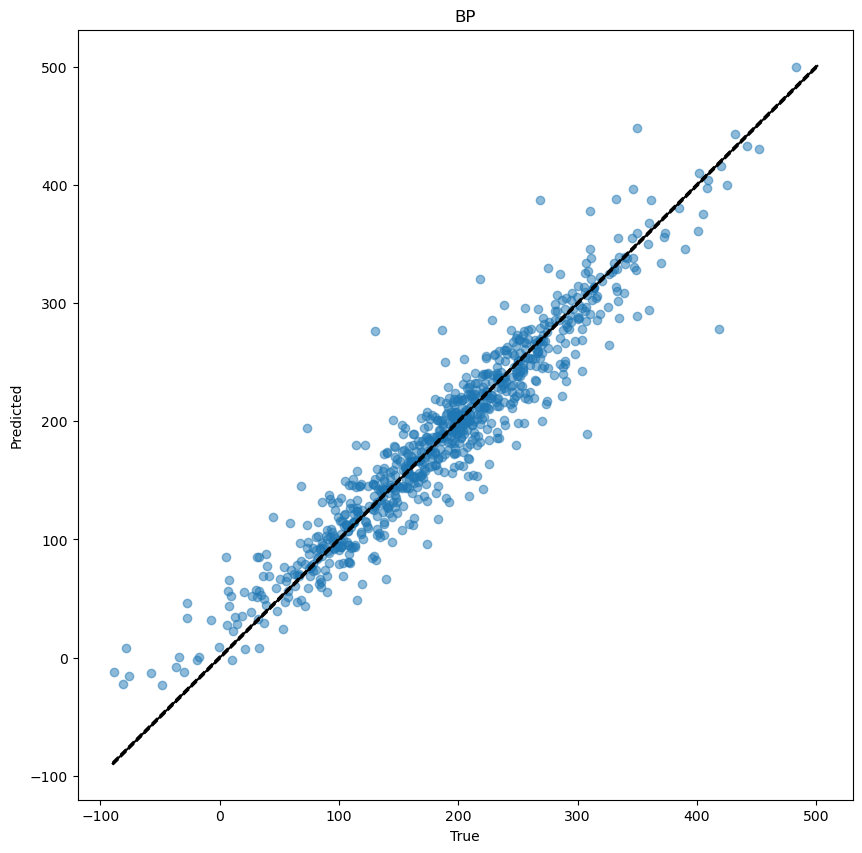

Property: LogHL
kendall_tau: 0.6823512897835317
rmse_overall: 1.0234626927080304
mae_overall: 0.786743319322258
within_03_overall: 0.26126126126126126
within_1_overall: 0.6936936936936937
R2: 0.7731542305629786
Pearson: 0.890202209372878


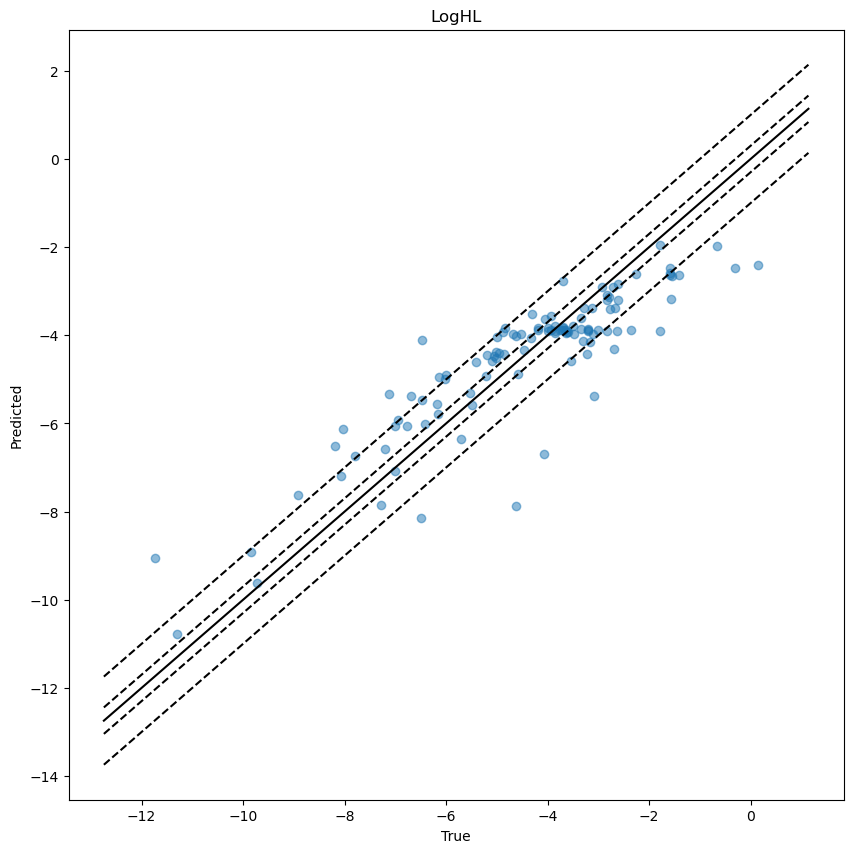

Property: LogKOA
kendall_tau: 0.8789915966386554
rmse_overall: 0.5294695418726336
mae_overall: 0.3928436621470111
within_03_overall: 0.5142857142857142
within_1_overall: 0.9428571428571428
R2: 0.970998290657205
Pearson: 0.9867114464290941


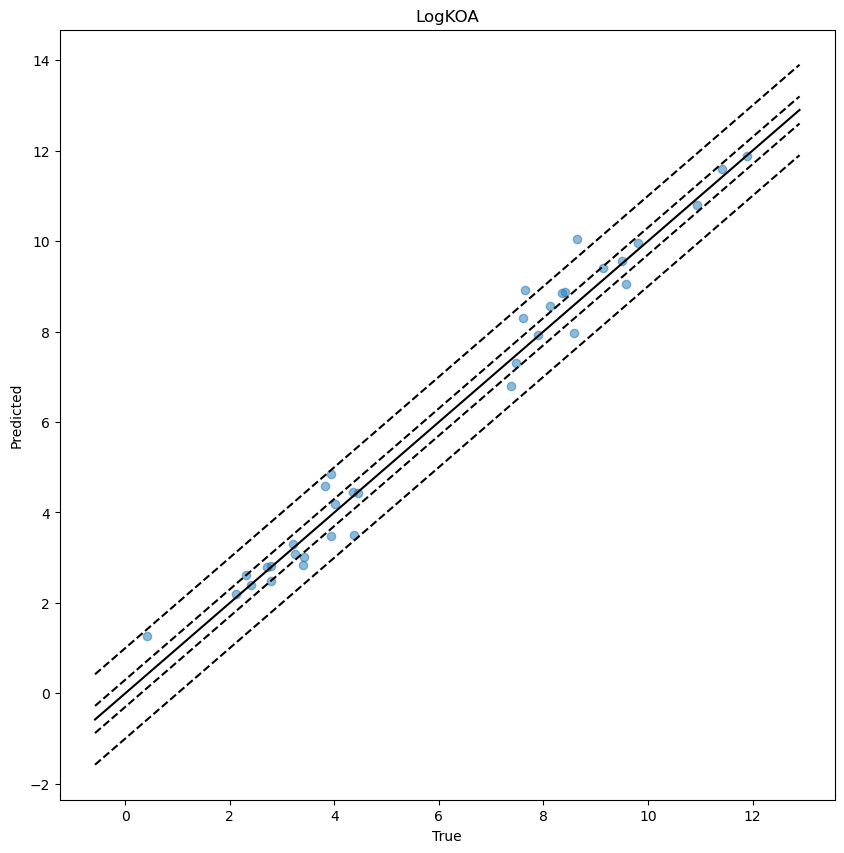

Property: MP
kendall_tau: 0.6913063386227449
rmse_overall: 49.99461059111237
mae_overall: 36.95571290094179
within_03_overall: 0.007959479015918957
within_1_overall: 0.017366136034732273
R2: 0.7528377470008333
Pearson: 0.8681338231920317


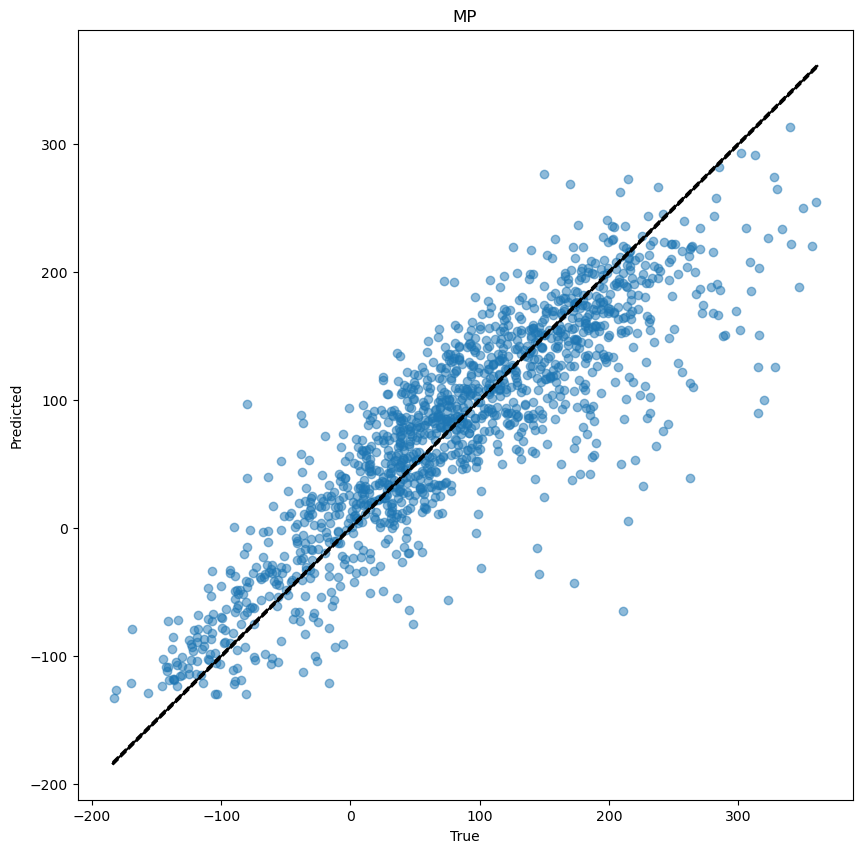

In [50]:
model.load_state_dict(torch.load('test_DASH_scaled_6props.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=props)
df_preds = vals_to_df(preds,props)
df_ys = vals_to_df(ys,props)
print(print_rmse_and_r2_scaled(df_preds,df_ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)

Loading previously created graphs
14686 3672
Epoch 1/100: Train Loss: 0.1397, Val Loss: 0.1048
Epoch 2/100: Train Loss: 0.0950, Val Loss: 0.0803
Epoch 3/100: Train Loss: 0.0772, Val Loss: 0.0760
Epoch 4/100: Train Loss: 0.0725, Val Loss: 0.0750
Epoch 5/100: Train Loss: 0.0718, Val Loss: 0.0711
Epoch 6/100: Train Loss: 0.0700, Val Loss: 0.0710
Epoch 7/100: Train Loss: 0.0696, Val Loss: 0.0662
Epoch 8/100: Train Loss: 0.0682, Val Loss: 0.0693
Epoch 9/100: Train Loss: 0.0683, Val Loss: 0.0676
Epoch 10/100: Train Loss: 0.0674, Val Loss: 0.0658
Epoch 11/100: Train Loss: 0.0657, Val Loss: 0.0668
Epoch 12/100: Train Loss: 0.0677, Val Loss: 0.0656
Epoch 13/100: Train Loss: 0.0643, Val Loss: 0.0643
Epoch 14/100: Train Loss: 0.0659, Val Loss: 0.0646
Epoch 15/100: Train Loss: 0.0649, Val Loss: 0.0651
Epoch 16/100: Train Loss: 0.0649, Val Loss: 0.0640
Epoch 17/100: Train Loss: 0.0634, Val Loss: 0.0698
Epoch 18/100: Train Loss: 0.0637, Val Loss: 0.0669
Epoch 19/100: Train Loss: 0.0629, Val Loss: 0.

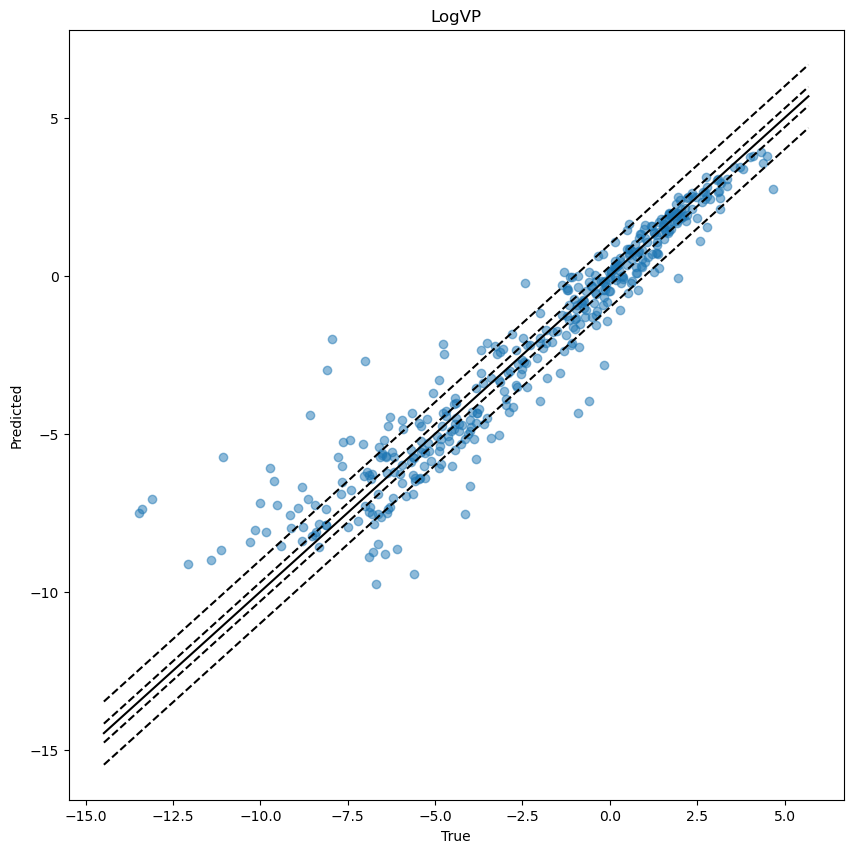

Property: LogP
kendall_tau: 0.7280192963602278
rmse_overall: 0.7812533125008866
mae_overall: 0.5795069526885757
within_03_overall: 0.34814475492441593
within_1_overall: 0.8437929454878608
R2: 0.8240503466969751
Pearson: 0.9077826138783347


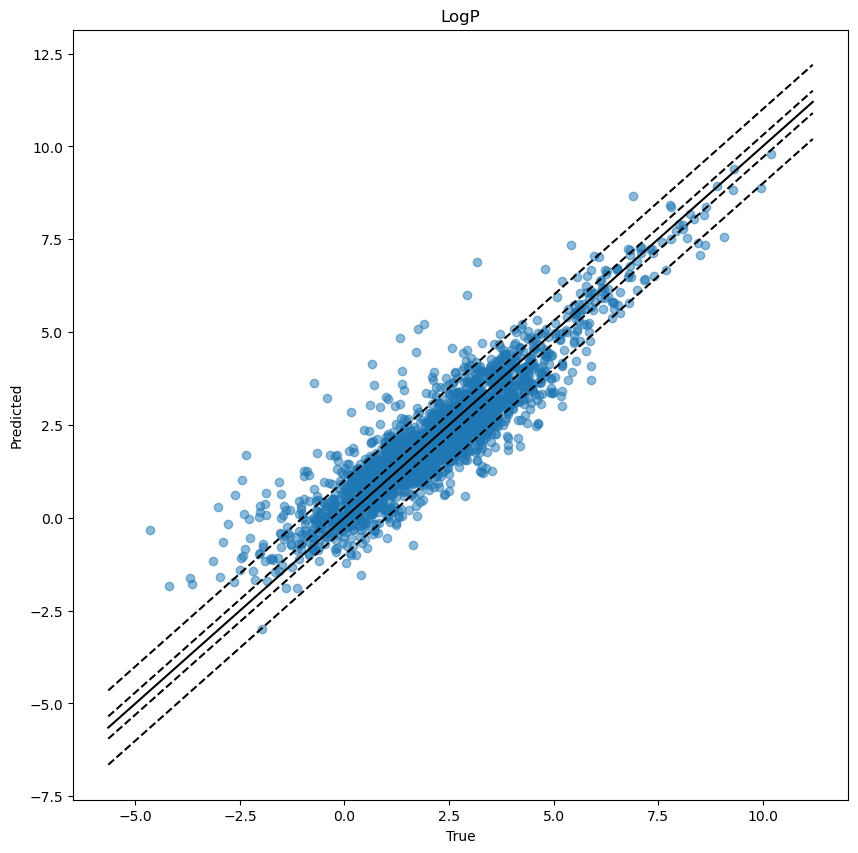

Property: BP
kendall_tau: 0.8093491071020025
rmse_overall: 27.758041850683806
mae_overall: 20.249148053222573
within_03_overall: 0.018072289156626505
within_1_overall: 0.046987951807228916
R2: 0.8996846124420711
Pearson: 0.9488021541275649


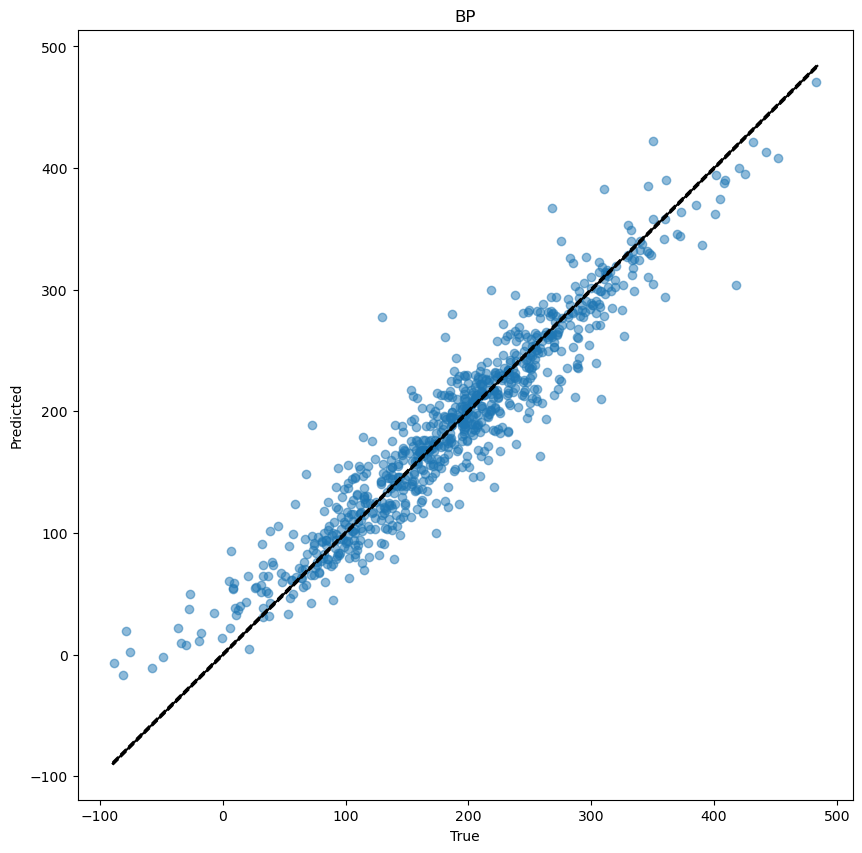

Property: LogHL
kendall_tau: 0.6456269531877817
rmse_overall: 1.0440090334077852
mae_overall: 0.8179662606623325
within_03_overall: 0.21621621621621623
within_1_overall: 0.7567567567567568
R2: 0.7639548048679488
Pearson: 0.8804282736150664


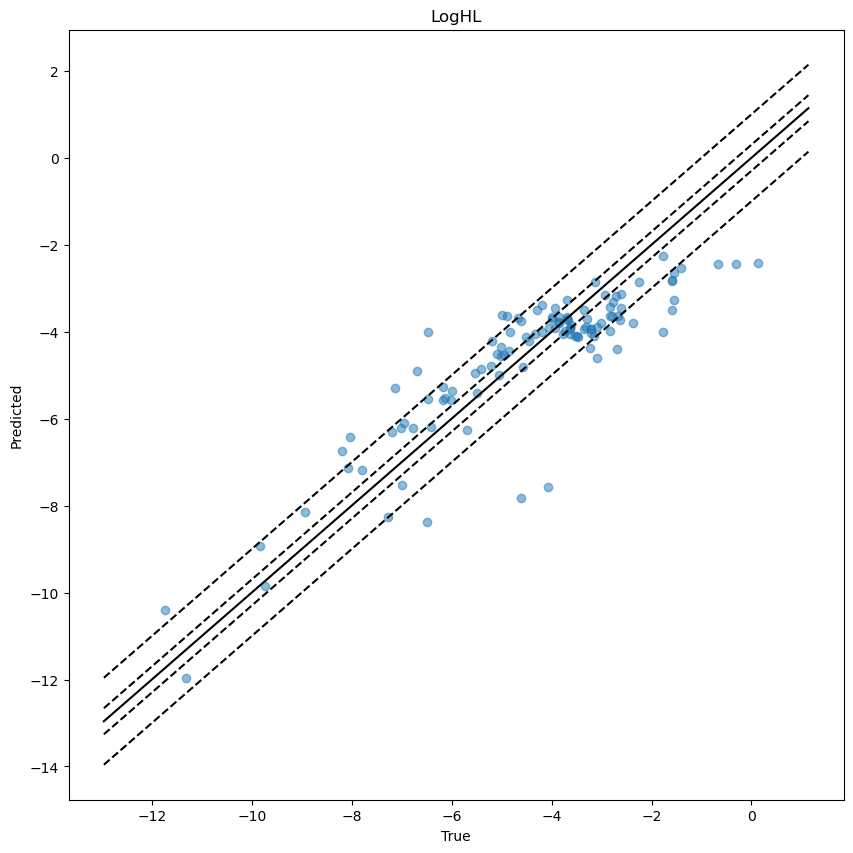

Property: LogKOA
kendall_tau: 0.8689075630252101
rmse_overall: 0.5990232635013317
mae_overall: 0.4297998827270098
within_03_overall: 0.5142857142857142
within_1_overall: 0.9428571428571428
R2: 0.962878201475374
Pearson: 0.981819827459117


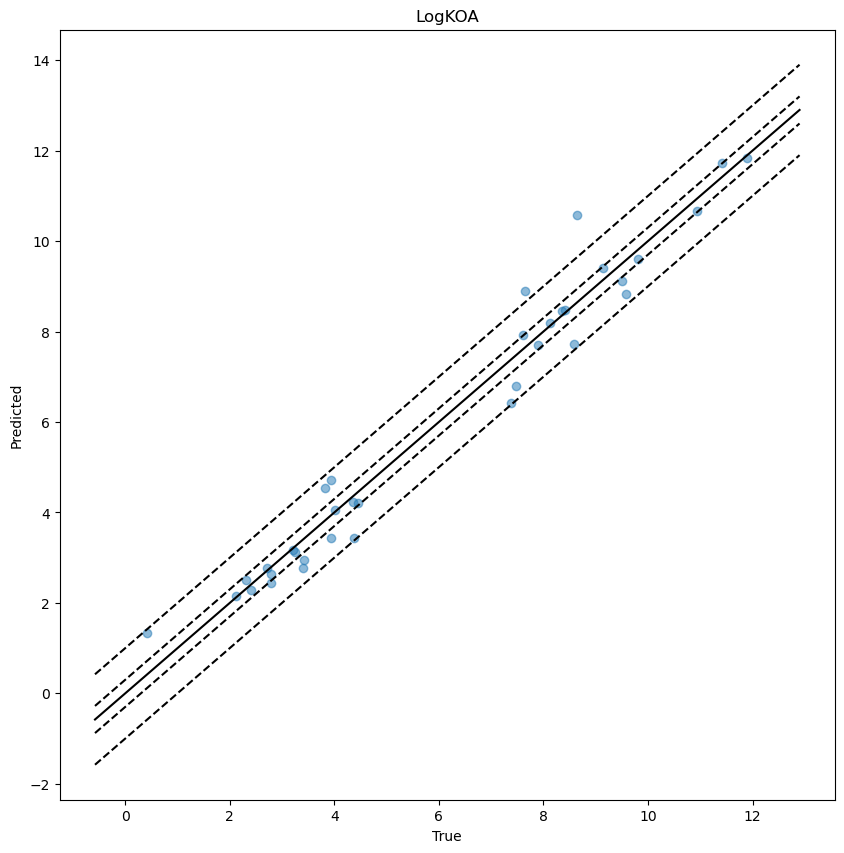

Property: MP
kendall_tau: 0.6925519998639347
rmse_overall: 50.595897199652235
mae_overall: 37.332658552499986
within_03_overall: 0.004341534008683068
within_1_overall: 0.016642547033285094
R2: 0.746856740182595
Pearson: 0.8645343369366709


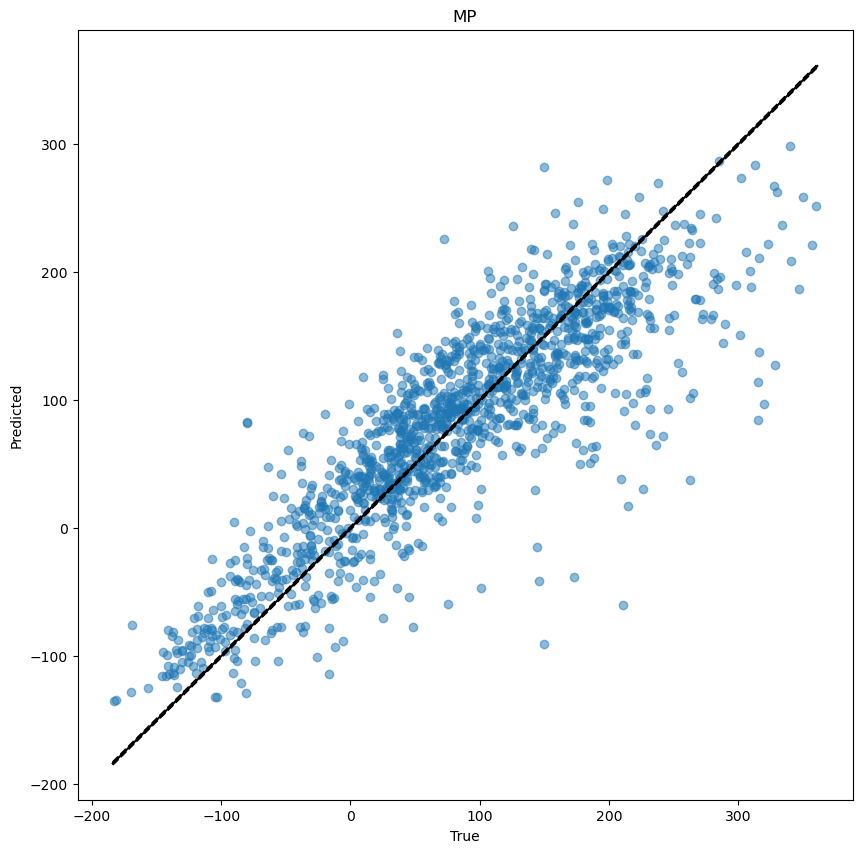

In [51]:
#test with some props that seem to be related at first glance: HL, KOA,LogP, MP,BP,VP
train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)
props = ['LogHL','LogKOA','LogP','MP','BP','LogVP']
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
name = "test_DASH_scaled_6props_add_complexity"
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=400, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=6, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=props,name=name)
model= AttentiveFP(in_channels=24, hidden_channels=400, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=6, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load(name+'.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=props)
df_preds = vals_to_df(preds,props)
df_ys = vals_to_df(ys,props)
print(print_rmse_and_r2_scaled(df_preds,df_ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)


To do:
1. Add the different endpoints - check
2. Normalization of values
3. Weighting of the tasks
4. Hyperparameter optimization
5. Benchmarking datasets? E.g. SAMPL7 for logP
6. Quadruple check refs - check
7. Think about datasplitting: same splits as OPERA? possible? otherwise, just cross-val? or random splits (multiple)
8. Different random weight initializations of the model


split: 80/20 5x

HP OPT: https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.bayesopt.BayesOptSearch.html
Repeated K-fold: https://greglandrum.github.io/rdkit-blog/posts/2023-08-13-xval-variability1.html